### UCI数据---- Adults

Data Set Information:

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)) 

Prediction task is to determine whether a person makes over 50K a year

In [129]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import xgboost as xgb

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import cross_validation as cv

In [27]:
import os,time

In [28]:
os.mkdir("feature")

FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: 'feature'

In [2]:

adult_data = "adult_data.txt"
data_train_gender = np.loadtxt(adult_data, dtype=str, delimiter=",", usecols=(9,14))

准备训练数据

In [148]:
names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", 
          "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]
train_data = pd.read_csv("adult_data.txt", names=names)

#train_data

In [157]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,4,77516,Bachelors,13,2,Adm-clerical,2,1,Male,2174,0,40,United-States,<=50K
1,50,2,83311,Bachelors,13,1,Exec-managerial,1,1,Male,0,0,13,United-States,<=50K
2,38,1,215646,HS-grad,9,3,Handlers-cleaners,2,1,Male,0,0,40,United-States,<=50K
3,53,1,234721,11th,7,1,Handlers-cleaners,1,2,Male,0,0,40,United-States,<=50K
4,28,1,338409,Bachelors,13,1,Prof-specialty,5,2,Female,0,0,40,Cuba,<=50K


In [151]:
train_data['workclass'] = train_data.workclass.str.replace('?', 'Other')

train_data['workclass'] = Series(map(workclass_trans, train_data.workclass.tolist()))

# marital_status :   str --> int
train_data['marital_status'] = Series(map(marital_trans, train_data.marital_status.tolist()))

# relation_ :   str --> int
train_data['relationship'] = Series(map(relation_trans, train_data.relationship.tolist()))

# race :   str --> int
train_data['race'] = Series(map(race_trans, train_data.race.tolist()))

In [117]:
def race_trans(obj):
    dic = {' White': 1,
           ' Black': 2,
           ' Asian-Pac-Islander': 3,
           ' Amer-Indian-Eskimo': 4,
           ' Other': 5}
    return dic[obj]

In [94]:
def workclass_trans(obj):
    dic = {' Private':1,
           ' Self-emp-not-inc':2,
           ' Local-gov':3,
           ' State-gov':4,
           ' Self-emp-inc':5,
           ' Federal-gov':6,
           ' Without-pay':7,
           ' Never-worked':8,
           ' Other':9}
    return dic[obj]

In [104]:
def marital_trans(obj):
    dic = {' Married-civ-spouse':1,
           ' Never-married':2, 
           ' Divorced': 3, 
           ' Separated': 4,
           ' Widowed': 5,
           ' Married-spouse-absent': 6,
           ' Married-AF-spouse': 7}
    return dic[obj]

In [111]:
def relation_trans(obj):
    dic = {' Husband': 1,
           ' Not-in-family': 2,
           ' Own-child': 3,
           ' Unmarried': 4,
           ' Wife': 5,
           ' Other-relative': 6}
    return dic[obj]

准备测试数据

In [170]:
# 读取测试数据
names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", 
          "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]
test_data = pd.read_csv("adult_test.txt", names=names)


In [173]:
test_data.head(3)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,1,226802,11th,7,2,Machine-op-inspct,3,2,Male,0,0,40,United-States,<=50K
1,38,1,89814,HS-grad,9,1,Farming-fishing,1,1,Male,0,0,50,United-States,<=50K
2,28,3,336951,Assoc-acdm,12,1,Protective-serv,1,1,Male,0,0,40,United-States,>50K


In [14]:
test_data.shape

(16281, 15)

In [172]:
#  测试数据处理
test_data['workclass'] = test_data.workclass.str.replace('?', 'Other')

test_data['workclass'] = Series(map(workclass_trans, test_data.workclass.tolist()))

# marital_status :   str --> int
test_data['marital_status'] = Series(map(marital_trans, test_data.marital_status.tolist()))

# relation_ :   str --> int
test_data['relationship'] = Series(map(relation_trans, test_data.relationship.tolist()))

# race :   str --> int
test_data['race'] = Series(map(race_trans, test_data.race.tolist()))

In [11]:
train_data.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [87]:
#train_data.age.value_counts()

In [18]:
fig = plt.figure()

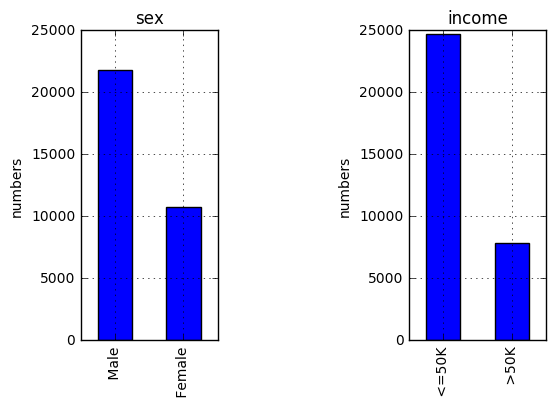

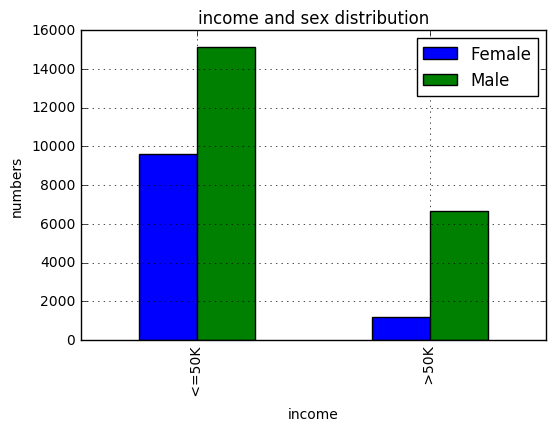

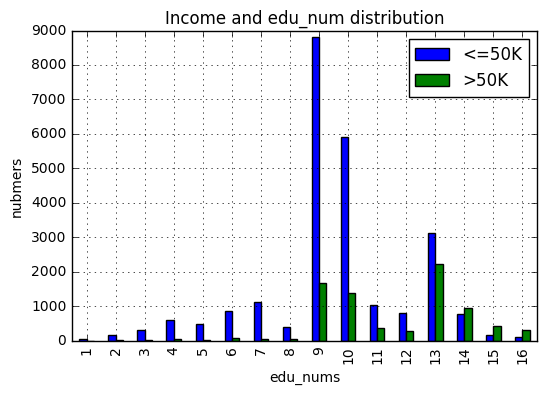

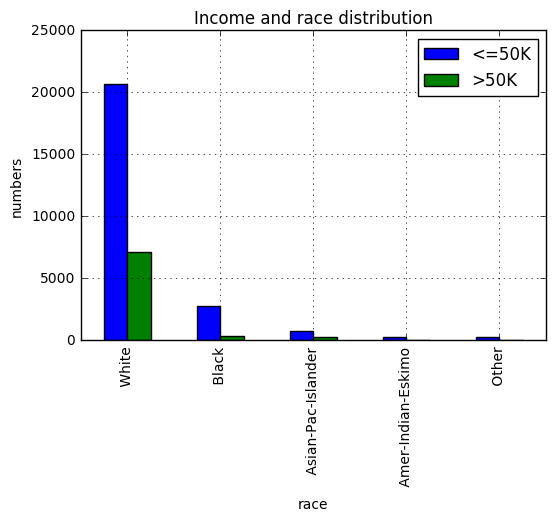

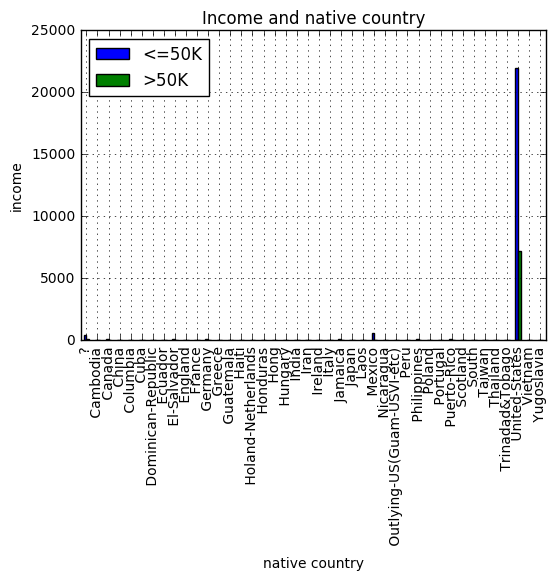

In [9]:
plt.subplot2grid((1,3), (0,0))
train_data.sex.value_counts().plot(kind='bar')
plt.title(u"sex")
plt.ylabel(u"numbers")
plt.grid()

plt.subplot2grid((1,3), (0,2))
train_data.income.value_counts().plot(kind='bar')
plt.title(u"income")
plt.ylabel(u"numbers")
plt.grid()


# income and sex
sex_income_male = train_data.income[train_data.sex==" Male"].value_counts()
sex_income_female = train_data.income[train_data.sex==" Female"].value_counts()
df = pd.DataFrame({u'Male':sex_income_male, u'Female':sex_income_female})
df.plot(kind='bar')
plt.title(u"income and sex distribution")
plt.xlabel(u"income")
plt.ylabel(u"numbers")
plt.grid()


# income and education_num
edu_income_more = train_data.education_num[train_data.income==" >50K"].value_counts()
edu_income_less = train_data.education_num[train_data.income==" <=50K"].value_counts()
df2 = pd.DataFrame({u'>50K':edu_income_more, u'<=50K':edu_income_less})
df2.plot(kind='bar')
plt.title("Income and edu_num distribution")
plt.xlabel("edu_nums")
plt.ylabel("nubmers")
plt.grid()


# income and race
race_income_more = train_data.race[train_data.income==" >50K"].value_counts()
race_income_less = train_data.race[train_data.income==" <=50K"].value_counts()
df = pd.DataFrame({u'>50K':race_income_more, u'<=50K':race_income_less})
df.plot(kind='bar')
plt.title("Income and race distribution")
plt.xlabel("race")
plt.ylabel("numbers")
plt.grid()


# income and native_country
na_county_more = train_data.native_country[train_data.income == " >50K"].value_counts()
na_county_less = train_data.native_country[train_data.income == " <=50K"].value_counts()
df_na = pd.DataFrame({u'>50K':na_county_more, u'<=50K':na_county_less})
df_na.plot(kind='bar')
plt.title("Income and native country")
plt.xlabel("native country")
plt.ylabel("income")
plt.grid()


plt.show()

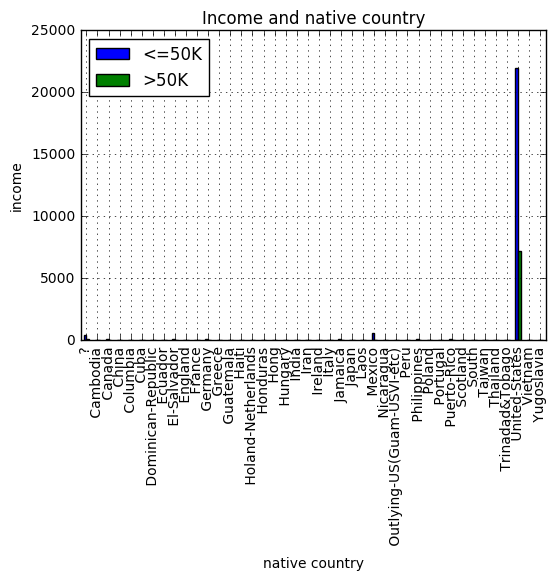

In [16]:
# income and native_country
na_county_more = train_data.native_country[train_data.income == " >50K"].value_counts()
na_county_less = train_data.native_country[train_data.income == " <=50K"].value_counts()
df_na = pd.DataFrame({u'>50K':na_county_more, u'<=50K':na_county_less})
df_na.plot(kind='bar')
plt.title("Income and native country")
plt.xlabel("native country")
plt.ylabel("income")
plt.grid()

plt.show()

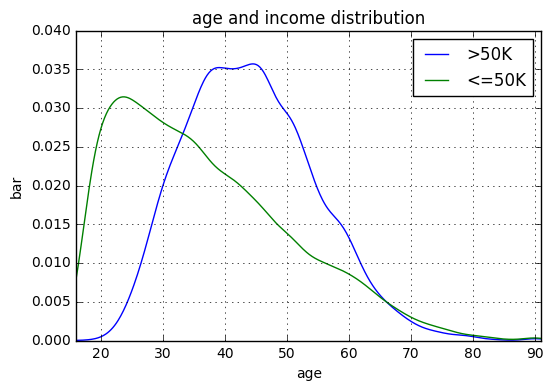

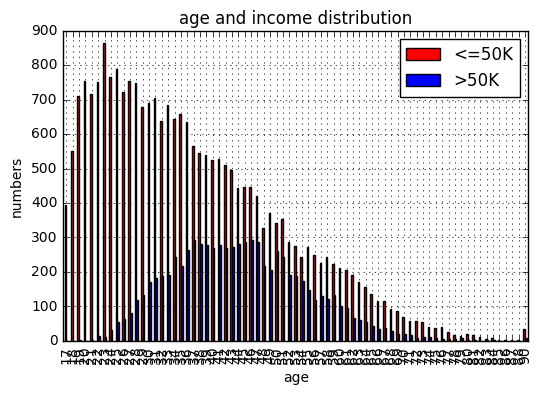

In [16]:
# age and income curve

train_data.age[train_data.income==" >50K"].plot(kind='kde')
train_data.age[train_data.income==" <=50K"].plot(kind='kde')
plt.xlabel("age")
plt.ylabel("bar")
plt.xlim(16,91)
plt.title("age and income distribution")
plt.legend((u'>50K', u'<=50K'), loc='best')
plt.grid()


age_income_more = train_data.age[train_data.income==" >50K"].value_counts()
age_income_less = train_data.age[train_data.income==" <=50K"].value_counts()
df = DataFrame({u'>50K':age_income_more, u'<=50K':age_income_less})
df.plot(kind='bar', color='rb')

plt.xlabel("age")
plt.ylabel("numbers")
plt.title("age and income distribution")
plt.grid()

plt.show()

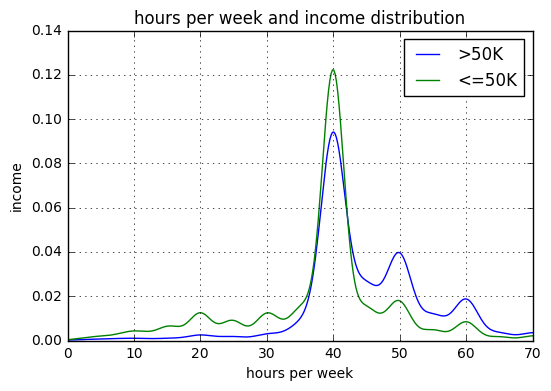

In [19]:
# hourse_per_week and income
fig.set(alpha=0.45)
train_data.hours_per_week[train_data.income==" >50K"].plot(kind='kde')
train_data.hours_per_week[train_data.income==" <=50K"].plot(kind='kde')
plt.xlabel("hours per week")
plt.ylabel("income")
plt.xlim(0,70)

plt.title("hours per week and income distribution")
plt.legend((u'>50K', u'<=50K'), loc='best')
plt.grid()
plt.show()

In [20]:
train_data.count()

age               32561
workclass         32561
fnlwgt            32561
education         32561
education_num     32561
marital_status    32561
occupation        32561
relationship      32561
race              32561
sex               32561
capital_gain      32561
capital_loss      32561
hours_per_week    32561
native_country    32561
income            32561
dtype: int64

In [522]:
#train_data.hours_per_week.value_counts()

In [507]:
plt.xticks?

In [488]:
# fnlwgt and income
train_data.fnlwgt[train_data.income==" >50K"].plot(kind='kde')
train_data.fnlwgt[train_data.income==" <=50K"].plot(kind='kde')
plt.xlabel("fnlwgt")
plt.ylabel("income")
plt.title("fnlwgt and income distribution")
plt.legend((u'>50K', u'<=50K'), loc='best')
plt.grid()
plt.show()

In [563]:
# capital_gain and income
train_data.capital_gain[train_data.income==" >50K"].plot(kind='kde')
train_data.capital_gain[train_data.income==" <=50K"].plot(kind='kde')
plt.xlabel("capital_gain")
plt.ylabel("income")
plt.title("capital_gain and income distribution")
plt.legend((u'>50K', u'<=50K'), loc='best')
plt.grid()
plt.show()

In [562]:
# capital_loss and income
train_data.capital_loss[train_data.income==" >50K"].plot(kind='kde')
train_data.capital_loss[train_data.income==" <=50K"].plot(kind='kde')
plt.xlabel("capital_loss")
plt.ylabel("income")
plt.title("capital_loss and income distribution")
plt.legend((u'>50K', u'<=50K'), loc='best')
plt.grid()
plt.show()

In [541]:
# 不同年龄段的男/女收入分布
age_sex_income_more = train_data.age[train_data.sex==" Male"][train_data.income==" >50K"].value_counts()
age_sex_income_less = train_data.age[train_data.sex==" Male"][train_data.income==" <=50K"].value_counts()

df = DataFrame({u'>50K':age_sex_income_more, u'<=50K':age_sex_income_less})
df.plot(kind='bar', stacked=True, color='rb')

plt.xlabel("age")
plt.ylabel("numbers")
plt.title("age and income distribution of male")
plt.grid()


# 不同年龄段的男/女收入分布
age_sex_income_more = train_data.age[train_data.sex==" Female"][train_data.income==" >50K"].value_counts()
age_sex_income_less = train_data.age[train_data.sex==" Female"][train_data.income==" <=50K"].value_counts()

df = DataFrame({u'>50K':age_sex_income_more, u'<=50K':age_sex_income_less})
df.plot(kind='bar', stacked=True, color='rb')

plt.xlabel("age")
plt.ylabel("numbers")
plt.title("age and time distribution of female")
plt.grid()
plt.show()


In [260]:
# 家庭中的角色与收入的分布关系
fig.set(alpha=0.45)
fig.set_size_inches(20, 10.5)
rel_income_more = train_data.relationship[train_data.income==" >50K"].value_counts()
rel_income_less = train_data.relationship[train_data.income==" <=50K"].value_counts()

df = pd.DataFrame({u'>50K': rel_income_more, u'<=50K': rel_income_less})
df.plot(kind='barh')
plt.title("Relationship and Income")
plt.xlabel("relationship")
plt.ylabel("numbers")
plt.grid()
plt.show()

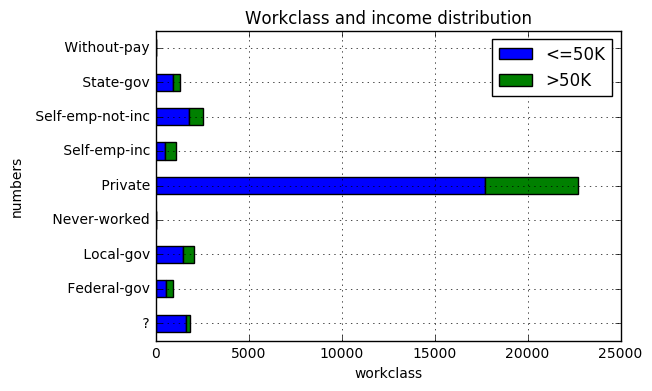

In [25]:
# workclass and income
work_income_more = train_data.workclass[train_data.income==" >50K"].value_counts()
work_income_less = train_data.workclass[train_data.income==" <=50K"].value_counts()
df = DataFrame({u'>50K':work_income_more, u'<=50K':work_income_less})
df.plot(kind='barh', stacked=True)
plt.title("Workclass and income distribution")
plt.xlabel("workclass")
plt.ylabel("numbers")
plt.grid()
plt.show()



In [567]:
train_data.race[train_data.income==" >50K"].value_counts()

 White                 7117
 Black                  387
 Asian-Pac-Islander     276
 Amer-Indian-Eskimo      36
 Other                   25
Name: race, dtype: int64

In [568]:
train_data.race[train_data.income==" <=50K"].value_counts()

 White                 20699
 Black                  2737
 Asian-Pac-Islander      763
 Amer-Indian-Eskimo      275
 Other                   246
Name: race, dtype: int64

In [55]:
data_train_gender[:10]
male_income = [x for x in data_train_gender if x[0]=="b' Male'"]
female_income = [x for x in data_train_gender if x[0]=="b' Female'"]

male_more = len([x for x in male_income if x[1]=="b' >50K'"])
male_less = len([x for x in male_income if x[1]=="b' <=50K'"])
female_more = len([x for x in female_income if x[1]=="b' >50K'"])
female_less = len([x for x in female_income if x[1]=="b' <=50K'"])

print("male: ", len(male_income))
print(("male_more: {0}, male_less: {1}").format(male_more, male_less))

print("female: ", len(female_income))
print(("female_more: {0}, female_less: {1}").format(female_more, female_less))

male:  21790
male_more: 6662, male_less: 15128
female:  10771
female_more: 1179, female_less: 9592


#### hours per week 特征进行离散化

In [174]:
hours_per_week_col = train_data.hours_per_week.map(lambda x: 1 if x==40 else 0)
#hours_per_week_col.head(10)


#### 提取训练数据的 continous 属性的特征， 及 label

In [178]:
# age	workclass	fnlwgt	education	education_num	marital_status	occupation	relationship	race	sex	capital_gain	capital_loss	hours_per_week	native_country	income

hours_per_week_col = train_data.hours_per_week.map(lambda x: 1 if x==40 else 0)
# 提取样本的所有 continuous 类型的特征
train_set = DataFrame(train_data, columns=['age', 'workclass', 'education_num', 'marital_status', 'relationship', 'race', 'sex', 'hours_per_week'])
print ("train set length: ", len(train_set))

train_set_label = pd.Series(train_data.income.map(lambda x: 1 if x==' >50K' else 0))
#print(type(data_for_train_label))

print("train set label length: ", len(train_set_label))
train_set.head(n=10)


# 添加 sex 特征
new_train_set = train_set.copy()
new_train_col = train_data.sex.replace({" Male":1, " Female":0})
new_train_set['sex'] = pd.Series(new_train_col)



# 添加离散化后的 hours_per_week 特征
new_train_set['hours_per_week'] = pd.Series(hours_per_week_col)



new_train_set['income'] = train_set_label
new_train_set.head(5)
new_train_set.to_csv("feature/xgb_train_data.csv", index=None)

train set length:  32561
train set label length:  32561


#### 提取测试数据的 continous 属性的特征， 及 label

In [176]:
# age	workclass	fnlwgt	education	education_num	marital_status	occupation	relationship	race	sex	capital_gain	capital_loss	hours_per_week	native_country	income

test_hours_per_week_col = test_data.hours_per_week.map(lambda x: 1 if x==40 else 0)
# 提取样本的所有 continuous 类型的特征
test_set = DataFrame(test_data, columns=['age', 'workclass', 'education_num', 'marital_status', 'relationship', 'race', 'sex', 'hours_per_week'])
print ("train set length: ", len(test_set))

test_set_label = pd.Series(test_data.income.map(lambda x: 1 if x==' >50K' else 0))
#print(type(data_for_train_label))

print("train set label length: ", len(test_set_label))
test_set.head(n=10)


# 添加 sex 特征
new_test_set = test_set.copy()
new_test_col = test_data.sex.replace({" Male":1, " Female":0})
new_test_set['sex'] = pd.Series(new_test_col)



# 添加离散化后的 hours_per_week 特征
new_test_set['hours_per_week'] = pd.Series(test_hours_per_week_col)



new_test_set['income'] = test_set_label
new_test_set.head(5)
new_test_set.to_csv("feature/xgb_test_data.csv", index=None)

train set length:  16281
train set label length:  16281


In [163]:
new_train_set.to_csv?

In [136]:
train_data.head(2)

0           age  workclass  education_num  marital_...
1           income
0       <=50K
1       <=50K
2   ...
dtype: object

#### 对 训练数据的 label 进行处理

In [483]:
label_dic = {" >50K":1, " <=50K":0}
sex_dic = {" Male":1, " Femal":0}
train_label = [label_dic[x[0]] for x in data_for_train_label.values]
#print(len(train_label))
#print(train_label[:10])

#### 提取测试数据的 contious 特征

In [590]:
test_set = DataFrame(test_data, columns=['age', 'education_num', 'hours_per_week'])
print ("test set length: ", len(test_set))


# 添加 sex 特征
new_test_set = test_set.copy()
new_test_col = test_data.sex.replace({" Male":1, " Female":0})
new_test_set['sex'] = pd.Series(new_test_col)
new_test_set.head(5)


#test_hours_per_week_col = test_data.hours_per_week.map(lambda x: 1 if x==40 else 0)
#test_hours_per_week_col.head(10)


# 添加离散化后的 hours_per_week 特征
new_test_set['hours_per_week'] = pd.Series(test_hours_per_week_col)

new_test_set.head(5)

test set length:  16281


,age,education_num,hours_per_week,sex
0,25,7,1,1
1,38,9,0,1
2,28,12,1,1
3,44,10,1,1
4,18,10,0,0


In [596]:
test_label.income.value_counts()/test_label.income.count()

 <=50K    0.763774
 >50K     0.236226
Name: income, dtype: float64

In [598]:
# 特征缩放
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()

In [599]:
test_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


#### 对测试数据的 label 进行处理

In [474]:
test_label = DataFrame(test_data, columns=['income'])
#print ("length of test_label: ", len(test_label))

test_set_label = [label_dic[x[0]] for x in test_label.values]
print(test_set_label[:10])

[0, 0, 1, 1, 0, 0, 0, 1, 0, 0]


In [569]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC

In [570]:
clf = LogisticRegressionCV(cv=10)
clf_svm = SVC()

In [556]:
clf.fit(new_train_set, train_label)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [571]:
clf_svm.fit(new_train_set, train_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [581]:
svc_prediction = clf_svm.predict(new_test_set)

#### LR预测

In [576]:
from sklearn.metrics import accuracy_score as acc_score

In [371]:
prediction = clf.predict(test_set)

In [579]:
acc_score?

In [580]:
score = acc_score(test_set_label, prediction)
print("score: ", score)
error = 1-score
print ("error: ", error)

score:  0.799090964928
error:  0.200909035072


#### SVC预测

In [585]:
svc_score = acc_score(test_set_label, svc_prediction)
print("accuracy: ", svc_score)
error = 1-svc_score
print("error: ", error)

accuracy:  0.771819912782
error:  0.228180087218


##### 所有 continuous 类型特征加入训练
score:  0.799275228794
error:  0.200724771206

In [560]:
weights = clf.coef_
print(weights)

[[ 0.04240404  0.36540655  1.28310195 -0.14688063]]


#### 对增加了 sex 特征后的数据进行训练



In [587]:
clf.fit(new_train_set, train_label)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [588]:
score = acc_score(test_set_label, clf.predict(new_test_set))
print("score: ", score)
error = 1-score
print ("error: ", error)

score:  0.768441741908
error:  0.231558258092


In [ ]:
score:  0.799398071372
error:  0.200601928628
[[ 0.04548398  0.35339825  0.03570044  1.12167643]]
    
score:  0.798231066888
error:  0.201768933112

In [ ]:
score = clf.score

In [296]:
data_for_train.head?